In [1]:
import os

import numpy as np
import pandas as pd
import scanpy as sc
import statsmodels.api as sm

# install the development version: pip install git+https://github.com/has2k1/plotnine.git
from plotnine import aes, coord_flip, facet_grid, geom_bar, ggplot, labs, theme_minimal

## Load data

In [2]:
WD = "/data/mibitof_breast_cancer"  # change as needed

In [3]:
adata = sc.read(os.path.join(WD, "mibitof_breast_phenotype_feature_matrices_zscore_Nenrichments.h5ad"))
adata

/dss/dsshome1/06/di93vel/.conda/envs/graph_venv/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
/dss/dsshome1/06/di93vel/.conda/envs/graph_venv/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
/dss/dsshome1/06/di93vel/.conda/envs/graph_venv/lib/python3.9/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 69672 × 59
    obs: 'event', 'Point_Num', 'CohortNumber', 'Tissue_Type', 'Status', 'Tissue', 'sublineage', 'phenotype', 'compartment', 'celllineage', 'sublineage_code', 'phenotype_code', 'compartment_code', 'celllineage_code', 'manual_gating_cellineage', 'manual_gating_subineage', 'manual_gating_phenotype', 'innerduct_mask', 'distal_mask', 'stroma_mask', 'periph_mask', 'epi_mask', 'duct_mask', 'myoep_mask', 'ERstatus', 'HER2status', 'ARstatus', 'Ki67status', 'pS6status', 'GLUT1status', 'HIF1astatus', 'COX2status', 'CD36status', 'CD44status', 'PD1status', 'PDL1status', 'IDO1status', 'GZMBstatus', 'ECADstatus', 'MMP9status', 'VIMstatus', 'FAPstatus', 'HLADRstatus', 'CD3status', 'SMAstatus', 'COLIstatus', 'CK5status', 'CK7status', 'P63status', 'myoep_dist_label', 'myoep_dist_MinDist', 'myoep_dist_MaxDist', 'myoep_dist_MedDist', 'myoep_dist_MeanDist', 'celltype_code', 'myoep_dist_MinDist1', 'Neighbor_dist_TUMOR', 'Neighbor_dist_MYOEP', 'Neighbor_dist_FI

In [4]:
# before filtering: 79 subjects
pd.unique(adata.obs.batch.values)

['0', '1', '2', '3', '4', ..., '74', '75', '76', '77', '78']
Length: 79
Categories (79, object): ['0', '1', '2', '3', ..., '75', '76', '77', '78']

In [5]:
# our condition column is called "Status"
adata.obs.Status.value_counts()

Status
ctrl      37684
case      12729
ipsinv    11792
normal     7467
Name: count, dtype: int64

In [6]:
# filtering: discard IBC ("ipsinv") patients
adata = adata[adata.obs["Status"].isin(["case", "ctrl", "normal"])]

In [7]:
# after filtering: 67 subjects
pd.unique(adata.obs.batch.values)

['0', '1', '2', '3', '4', ..., '74', '75', '76', '77', '78']
Length: 67
Categories (67, object): ['0', '1', '2', '3', ..., '75', '76', '77', '78']

## Inspect data

To generate `adata.uns['celltype_interaction']` and `adata.uns['neighborhood_composition']`, run the "01_neighborhood_enrichment_mibitof.ipynb" notebook.

In [8]:
adata.uns["celltype_interaction"]

,APC_APC,APC_BCELL,APC_CAF,APC_CD4T,APC_CD8T,APC_DC,APC_ENDO,APC_FIBRO_VIMonly,APC_IMMUNEOTHER,APC_MACS,...,TUMOR_CK5_TUMOR_CK5,TUMOR_CK5_TUMOR_ECADCK,TUMOR_CK5_TUMOR_EMT,TUMOR_CK5_TUMOR_LUMINAL,TUMOR_ECADCK_TUMOR_ECADCK,TUMOR_ECADCK_TUMOR_EMT,TUMOR_ECADCK_TUMOR_LUMINAL,TUMOR_EMT_TUMOR_EMT,TUMOR_EMT_TUMOR_LUMINAL,TUMOR_LUMINAL_TUMOR_LUMINAL
0,-0.252646,-0.266207,4.106290,4.007559,0.865354,0.000000,1.964038,-0.652286,0.000000,-0.575549,...,-0.480192,0.510561,-0.621259,-0.899666,-1.318091,0.940154,-0.764992,-0.300444,-0.295845,2.058598
1,2.442178,0.882166,2.341118,-0.188850,-1.307334,0.000000,1.200766,-1.326858,-0.806004,-1.261871,...,-0.791063,2.968883,-0.580584,-0.220749,-0.643033,-1.088183,0.593765,-0.166581,1.324708,0.917013
10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.193525,-0.217072,-0.160128,-0.292876,...,5.590891,0.616937,-0.163383,-0.348235,5.006062,-0.207129,2.727826,0.000000,-0.208464,0.201981
11,-0.817048,0.000000,0.000000,0.000000,-0.531878,0.000000,-0.512575,3.073051,-1.053428,-0.304290,...,-0.228424,-0.855889,-0.424202,2.513383,-0.176759,1.887292,1.259407,-0.296976,-0.839240,0.621327
12,1.555593,-0.240192,-0.436968,-0.695358,0.905322,0.000000,-0.311656,0.363164,-1.144735,-0.348776,...,-0.083960,-0.645483,3.489547,-1.071855,7.650707,0.688001,1.942268,1.369053,0.893036,0.439677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,-0.565032,0.000000,-0.238919,2.594150,0.000000,-0.270114,-0.346786,1.240552,2.281252,0.871465,...,0.000000,1.844948,-0.735413,-0.070888,7.401843,3.215831,0.354046,0.112923,0.876779,0.000000
77,-0.595204,0.789765,0.761532,0.722478,0.692523,0.894054,0.647351,-0.043450,-0.754476,-0.202315,...,1.552340,-0.109828,-0.464639,-1.230711,-1.220524,-0.771895,1.611822,-0.958526,0.899761,1.375697
78,2.423646,0.176154,5.010385,2.088819,2.222009,2.751560,3.818849,1.712359,0.175387,2.910967,...,0.032630,-0.646336,0.438127,2.465337,-0.089803,-0.254526,0.288518,-0.163813,-0.732320,7.587140
8,1.301336,0.000000,-0.572530,5.140600,3.946483,-0.836396,0.199601,7.209128,-1.101945,-1.018551,...,0.000000,0.000000,0.000000,0.000000,-0.222271,-0.169725,-1.140811,0.000000,-0.532017,1.750711


In [9]:
adata.uns["neighborhood_composition"]

,APC,BCELL,CAF,CD4T,CD8T,DC,ENDO,FIBRO_VIMonly,IMMUNEOTHER,MACS,...,MYOEP,MYOFIBRO,NEUT,NORMFIBRO,OTHER,TCELL,TUMOR_CK5,TUMOR_ECADCK,TUMOR_EMT,TUMOR_LUMINAL
labels_id,,,,,,,,,,,,,,,,,,,,,
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,3
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,2
10,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,2,0,2
11,0,0,2,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
13,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1317,1,0,0,1,0,0,1,1,1,1,...,0,1,0,0,0,0,0,0,0,0
1321,0,0,0,0,0,0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,4
1342,2,0,1,1,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Experiment design

Extract the batch and condition ('Status') column from the AnnData object.

In [10]:
group = adata.obs[["library_id", "batch", "Status"]].copy()  # change as needed
group.drop_duplicates(inplace=True)
group.set_index("library_id", inplace=True)
group

,batch,Status
library_id,,
0,0,ctrl
1,1,ctrl
2,2,ctrl
3,3,ctrl
4,4,ctrl
...,...,...
74,74,case
75,75,case
76,76,case


In [11]:
print(group.batch.cat.categories)
print(group.Status.cat.categories)

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '48', '52', '60',
       '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72',
       '73', '74', '75', '76', '77', '78'],
      dtype='object')
Index(['case', 'ctrl', 'normal'], dtype='object')


In [12]:
condition = group.Status  # change as needed
patient = group.batch  # change as needed

In [13]:
interaction_mat = adata.uns["celltype_interaction"]
interaction_mat["condition"] = condition
interaction_mat["subject_id"] = patient

In [14]:
interaction_mat

,APC_APC,APC_BCELL,APC_CAF,APC_CD4T,APC_CD8T,APC_DC,APC_ENDO,APC_FIBRO_VIMonly,APC_IMMUNEOTHER,APC_MACS,...,TUMOR_CK5_TUMOR_EMT,TUMOR_CK5_TUMOR_LUMINAL,TUMOR_ECADCK_TUMOR_ECADCK,TUMOR_ECADCK_TUMOR_EMT,TUMOR_ECADCK_TUMOR_LUMINAL,TUMOR_EMT_TUMOR_EMT,TUMOR_EMT_TUMOR_LUMINAL,TUMOR_LUMINAL_TUMOR_LUMINAL,condition,subject_id
0,-0.252646,-0.266207,4.106290,4.007559,0.865354,0.000000,1.964038,-0.652286,0.000000,-0.575549,...,-0.621259,-0.899666,-1.318091,0.940154,-0.764992,-0.300444,-0.295845,2.058598,ctrl,0
1,2.442178,0.882166,2.341118,-0.188850,-1.307334,0.000000,1.200766,-1.326858,-0.806004,-1.261871,...,-0.580584,-0.220749,-0.643033,-1.088183,0.593765,-0.166581,1.324708,0.917013,ctrl,1
10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.193525,-0.217072,-0.160128,-0.292876,...,-0.163383,-0.348235,5.006062,-0.207129,2.727826,0.000000,-0.208464,0.201981,case,10
11,-0.817048,0.000000,0.000000,0.000000,-0.531878,0.000000,-0.512575,3.073051,-1.053428,-0.304290,...,-0.424202,2.513383,-0.176759,1.887292,1.259407,-0.296976,-0.839240,0.621327,ctrl,11
12,1.555593,-0.240192,-0.436968,-0.695358,0.905322,0.000000,-0.311656,0.363164,-1.144735,-0.348776,...,3.489547,-1.071855,7.650707,0.688001,1.942268,1.369053,0.893036,0.439677,case,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,-0.565032,0.000000,-0.238919,2.594150,0.000000,-0.270114,-0.346786,1.240552,2.281252,0.871465,...,-0.735413,-0.070888,7.401843,3.215831,0.354046,0.112923,0.876779,0.000000,case,76
77,-0.595204,0.789765,0.761532,0.722478,0.692523,0.894054,0.647351,-0.043450,-0.754476,-0.202315,...,-0.464639,-1.230711,-1.220524,-0.771895,1.611822,-0.958526,0.899761,1.375697,case,77
78,2.423646,0.176154,5.010385,2.088819,2.222009,2.751560,3.818849,1.712359,0.175387,2.910967,...,0.438127,2.465337,-0.089803,-0.254526,0.288518,-0.163813,-0.732320,7.587140,ctrl,78
8,1.301336,0.000000,-0.572530,5.140600,3.946483,-0.836396,0.199601,7.209128,-1.101945,-1.018551,...,0.000000,0.000000,-0.222271,-0.169725,-1.140811,0.000000,-0.532017,1.750711,normal,8


In [15]:
sum(interaction_mat.condition.isna())

12

In [16]:
interaction_mat = pd.melt(interaction_mat, id_vars=["condition", "subject_id"])
interaction_mat.shape

(21804, 4)

## Prepare experiment

In [17]:
condition

library_id
0     ctrl
1     ctrl
2     ctrl
3     ctrl
4     ctrl
      ... 
74    case
75    case
76    case
77    case
78    ctrl
Name: Status, Length: 67, dtype: category
Categories (3, object): ['case', 'ctrl', 'normal']

In [18]:
len(condition)

67

In [19]:
cell_type_interaction_mat = interaction_mat.copy()

In [20]:
cell_type_interaction_mat["subject_id"] = cell_type_interaction_mat["subject_id"].astype("category")
cell_type_interaction_mat["condition"] = cell_type_interaction_mat["condition"].astype("category")
cell_type_interaction_mat["condition"] = cell_type_interaction_mat["condition"].cat.reorder_categories(
    ["normal", "case", "ctrl"], ordered=True
)
cell_type_interaction_mat.head()

,condition,subject_id,variable,value
0,ctrl,0,APC_APC,-0.252646
1,ctrl,1,APC_APC,2.442178
2,case,10,APC_APC,0.000000
3,ctrl,11,APC_APC,-0.817048
4,case,12,APC_APC,1.555593


In [21]:
cell_type_interaction_mat.shape

(21804, 4)

## (Generalized) Linear Model

In [22]:
model = sm.formula.ols(formula="value ~ subject_id + variable * condition", data=cell_type_interaction_mat).fit()

In [23]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     4.108
Date:                Sun, 03 Mar 2024   Prob (F-statistic):          7.17e-290
Time:                        01:01:23   Log-Likelihood:                -29273.
No. Observations:               18492   AIC:                         6.033e+04
Df Residuals:                   17600   BIC:                         6.731e+04
Df Model:                         891                                         
Covariance Type:            nonrobust                                         
=============================================================================================================================
                                                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
Intercept                                                     0.1775      0.305      0.582      0.561      -0.421       0.776
subject_id[T.1]                                               0.0057      0.103      0.056      0.956      -0.196       0.207
subject_id[T.2]                                               0.1645      0.103      1.600      0.110      -0.037       0.366
subject_id[T.3]                                               0.0083      0.103      0.080      0.936      -0.193       0.210
subject_id[T.4]                                              -0.0874      0.103     -0.850      0.395      -0.289       0.114
subject_id[T.5]                                              -0.0604      0.103     -0.587      0.557      -0.262       0.141
subject_id[T.6]                                              -0.1523      0.124     -1.227      0.220      -0.396       0.091
subject_id[T.7]                                               0.2624      0.076      3.472      0.001       0.114       0.411
subject_id[T.8]                                              -0.2028      0.124     -1.634      0.102      -0.446       0.040
subject_id[T.9]                                              -0.0155      0.103     -0.150      0.880      -0.217       0.186
subject_id[T.10]                                              0.0636      0.076      0.842      0.400      -0.084       0.212
subject_id[T.11]                                             -0.0811      0.103     -0.789      0.430      -0.283       0.120
subject_id[T.12]                                              0.0817      0.076      1.082      0.279      -0.066       0.230
subject_id[T.13]                                              0.0785      0.103      0.764      0.445      -0.123       0.280
subject_id[T.14]                                             -0.1808      0.124     -1.457      0.145      -0.424       0.062
subject_id[T.15]                                             -0.0124      0.103     -0.121      0.904      -0.214       0.189
subject_id[T.16]                                             -0.0247      0.103     -0.240      0.810      -0.226       0.177
subject_id[T.17]                                              0.0490      0.103      0.476      0.634      -0.153       0.251
subject_id[T.18]                                             -0.0184      0.103     -0.179      0.858      -0.220       0.183
subject_id[T.19]                                             -0.0134      0.076     -0.178      0.859      -0.162       0.135
subject_id[T.20]                                             -0.1879      0.124     -1.514      0.130      -0.431       0.055
subject_id[T.21]                                           

## Inspect significant coefficients

In [24]:
(model.pvalues < 0.05).sum()

242

In [25]:
significant_coef_names = model.params[model.pvalues < 0.01].index.tolist()
print(significant_coef_names)

['subject_id[T.7]', 'subject_id[T.42]', 'variable[T.APC_FIBRO_VIMonly]', 'variable[T.CD8T_FIBRO_VIMonly]', 'variable[T.ENDO_FIBRO_VIMonly]', 'variable[T.FIBRO_VIMonly_FIBRO_VIMonly]', 'variable[T.FIBRO_VIMonly_MYOEP]', 'variable[T.FIBRO_VIMonly_TUMOR_LUMINAL]', 'condition[T.ctrl]', 'variable[T.APC_TUMOR_ECADCK]:condition[T.case]', 'variable[T.APC_TUMOR_LUMINAL]:condition[T.case]', 'variable[T.BCELL_ENDO]:condition[T.case]', 'variable[T.CAF_TUMOR_ECADCK]:condition[T.case]', 'variable[T.CD4T_TUMOR_ECADCK]:condition[T.case]', 'variable[T.CD8T_CD8T]:condition[T.case]', 'variable[T.CD8T_FIBRO_VIMonly]:condition[T.case]', 'variable[T.ENDO_TUMOR_ECADCK]:condition[T.case]', 'variable[T.ENDO_TUMOR_LUMINAL]:condition[T.case]', 'variable[T.FIBRO_VIMonly_FIBRO_VIMonly]:condition[T.case]', 'variable[T.FIBRO_VIMonly_TUMOR_ECADCK]:condition[T.case]', 'variable[T.FIBRO_VIMonly_TUMOR_LUMINAL]:condition[T.case]', 'variable[T.IMMUNEOTHER_NORMFIBRO]:condition[T.case]', 'variable[T.IMMUNEOTHER_TUMOR_ECADCK

In [26]:
signif_coefs = model.params[model.pvalues < 0.01]
ggdat = pd.DataFrame({"coef_label": signif_coefs.index, "pvals": model.pvalues[model.pvalues < 0.01]})
ggdat.head()

,coef_label,pvals
subject_id[T.7],subject_id[T.7],0.000519
subject_id[T.42],subject_id[T.42],0.006822
variable[T.APC_FIBRO_VIMonly],variable[T.APC_FIBRO_VIMonly],0.000826
variable[T.CD8T_FIBRO_VIMonly],variable[T.CD8T_FIBRO_VIMonly],0.000025
variable[T.ENDO_FIBRO_VIMonly],variable[T.ENDO_FIBRO_VIMonly],0.002770


In [27]:
ggdat = ggdat[ggdat["coef_label"].str.contains("condition")]
ggdat

,coef_label,pvals
condition[T.ctrl],condition[T.ctrl],0.002765
variable[T.APC_TUMOR_ECADCK]:condition[T.case],variable[T.APC_TUMOR_ECADCK]:condition[T.case],0.000243
variable[T.APC_TUMOR_LUMINAL]:condition[T.case],variable[T.APC_TUMOR_LUMINAL]:condition[T.case],0.000067
variable[T.BCELL_ENDO]:condition[T.case],variable[T.BCELL_ENDO]:condition[T.case],0.002882
variable[T.CAF_TUMOR_ECADCK]:condition[T.case],variable[T.CAF_TUMOR_ECADCK]:condition[T.case],0.005676
...,...,...
variable[T.NEUT_TUMOR_ECADCK]:condition[T.ctrl],variable[T.NEUT_TUMOR_ECADCK]:condition[T.ctrl],0.001215
variable[T.NEUT_TUMOR_EMT]:condition[T.ctrl],variable[T.NEUT_TUMOR_EMT]:condition[T.ctrl],0.005332
variable[T.NORMFIBRO_NORMFIBRO]:condition[T.ctrl],variable[T.NORMFIBRO_NORMFIBRO]:condition[T.ctrl],0.005360
variable[T.NORMFIBRO_TUMOR_EMT]:condition[T.ctrl],variable[T.NORMFIBRO_TUMOR_EMT]:condition[T.ctrl],0.004868


In [28]:
# extract conditions from DataFrame index
ggdat["condition"] = ggdat.index.str.extract(r":condition\[T\.([^\]]+)\]")[0].values
# extract cell pairs from DataFrame index
ggdat["coef_label"] = ggdat.index.str.extract(r"variable\[T\.([^\]]+)\]:condition")[0].values
ggdat

,coef_label,pvals,condition
condition[T.ctrl],NaN,0.002765,NaN
variable[T.APC_TUMOR_ECADCK]:condition[T.case],APC_TUMOR_ECADCK,0.000243,case
variable[T.APC_TUMOR_LUMINAL]:condition[T.case],APC_TUMOR_LUMINAL,0.000067,case
variable[T.BCELL_ENDO]:condition[T.case],BCELL_ENDO,0.002882,case
variable[T.CAF_TUMOR_ECADCK]:condition[T.case],CAF_TUMOR_ECADCK,0.005676,case
...,...,...,...
variable[T.NEUT_TUMOR_ECADCK]:condition[T.ctrl],NEUT_TUMOR_ECADCK,0.001215,ctrl
variable[T.NEUT_TUMOR_EMT]:condition[T.ctrl],NEUT_TUMOR_EMT,0.005332,ctrl
variable[T.NORMFIBRO_NORMFIBRO]:condition[T.ctrl],NORMFIBRO_NORMFIBRO,0.005360,ctrl
variable[T.NORMFIBRO_TUMOR_EMT]:condition[T.ctrl],NORMFIBRO_TUMOR_EMT,0.004868,ctrl


In [29]:
ggdat["neg_log_pvals"] = -np.log10(ggdat["pvals"])
ggdat

,coef_label,pvals,condition,neg_log_pvals
condition[T.ctrl],NaN,0.002765,NaN,2.558244
variable[T.APC_TUMOR_ECADCK]:condition[T.case],APC_TUMOR_ECADCK,0.000243,case,3.615266
variable[T.APC_TUMOR_LUMINAL]:condition[T.case],APC_TUMOR_LUMINAL,0.000067,case,4.174845
variable[T.BCELL_ENDO]:condition[T.case],BCELL_ENDO,0.002882,case,2.540267
variable[T.CAF_TUMOR_ECADCK]:condition[T.case],CAF_TUMOR_ECADCK,0.005676,case,2.245952
...,...,...,...,...
variable[T.NEUT_TUMOR_ECADCK]:condition[T.ctrl],NEUT_TUMOR_ECADCK,0.001215,ctrl,2.915554
variable[T.NEUT_TUMOR_EMT]:condition[T.ctrl],NEUT_TUMOR_EMT,0.005332,ctrl,2.273080
variable[T.NORMFIBRO_NORMFIBRO]:condition[T.ctrl],NORMFIBRO_NORMFIBRO,0.005360,ctrl,2.270846
variable[T.NORMFIBRO_TUMOR_EMT]:condition[T.ctrl],NORMFIBRO_TUMOR_EMT,0.004868,ctrl,2.312636


In [30]:
ggdat = ggdat.dropna(subset=["coef_label"])

In [31]:
p = (
    ggplot(ggdat, aes(x="coef_label", y="neg_log_pvals", fill="condition"))
    + geom_bar(stat="identity", position="dodge")
    + coord_flip()
    + theme_minimal(base_size=6)
    + facet_grid(".~condition")
    + labs(x="celltype-celltype neighborhood enrichment")
)

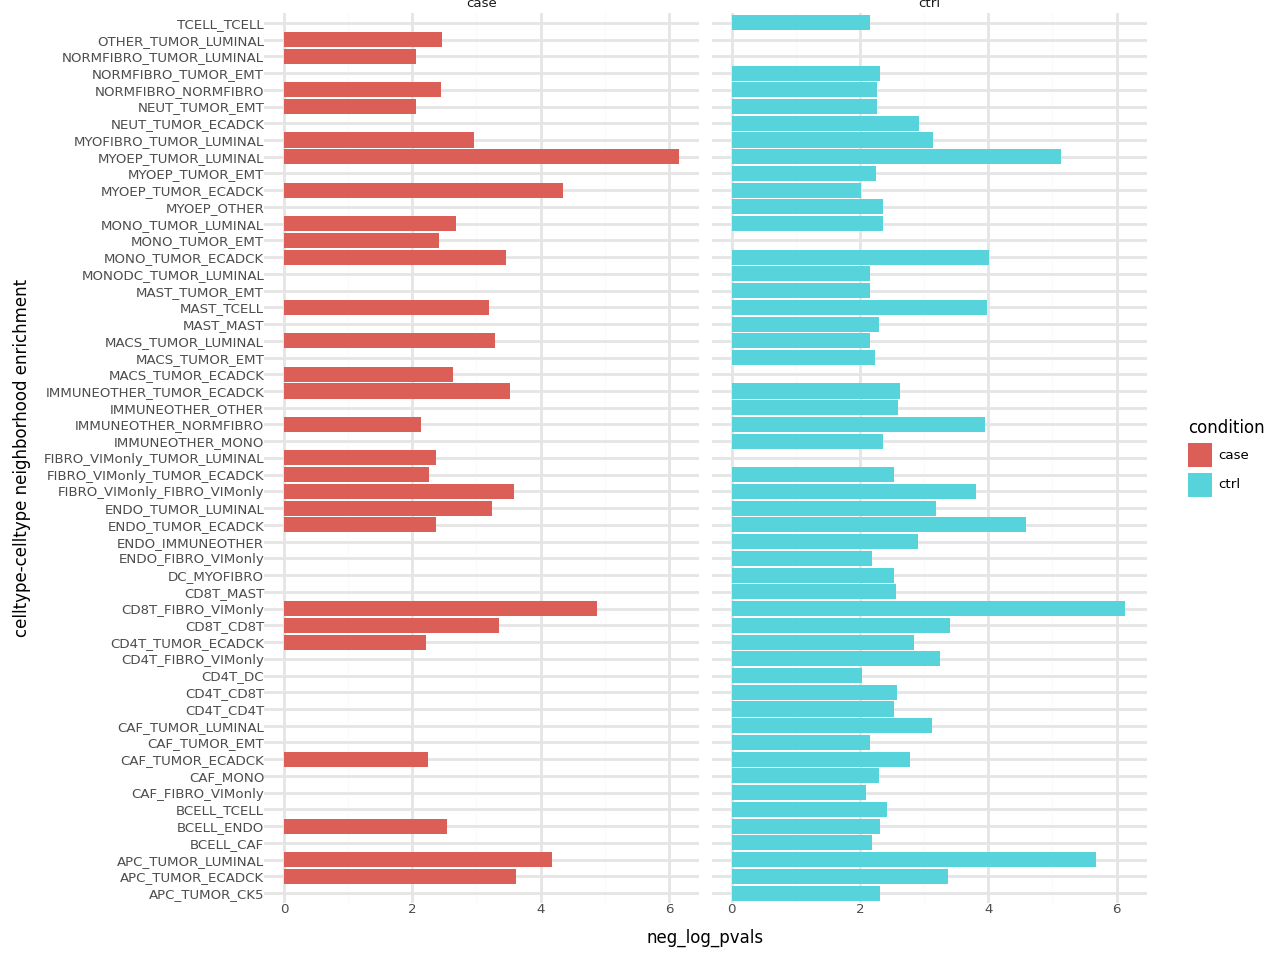

In [32]:
p